In [57]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import contrib 
import pandas as pd
from tensorflow.python.framework import ops
import urllib
import random
from math import exp
from math import log

%matplotlib inline


In [68]:
# Import and format data helper function
def format_data(filename):
    training = open(filename)
    header = training.readline()
    fields = header.strip().replace('"','').split(',')
    featureNames = fields[:-1]
    labelName = fields[-1]
    lines = [[float(x) for x in l.split(',')] for l in training]
    X = [l[:-1] for l in lines]
    Y = [l[-1] for l in lines]
    X = np.array(X).T
    Y = np.array(Y)
    Y = Y.astype(int)
    nb_classes = 15
    Y = np.eye(nb_classes)[Y]
    Y = np.roll(Y,2)
    print(Y[0,])
    return X.T, Y

In [69]:
# Import and Format Training Set
X_train, Y_train = format_data('training.csv')

# Import and Format Dev Set
X_dev, Y_dev = format_data('dev.csv')


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(88616, 15)
(88616, 12)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(6129, 15)
(6129, 12)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(6129, 15)
(6129, 12)


In [60]:
# Create Placeholder needed for latter use
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [None, n_x])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [61]:
# Initialize necessary parameters for NN
def initialize_parameters():
    W1 = tf.get_variable("W1", [25,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [15, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [15,1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [62]:
# Forward_propagation Function
def forward_propagation(X, parameters):    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,tf.transpose(X)),b1)                                             # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                               # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                               # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)      
    return Z3

In [63]:
# Compute_cost using softmax cross entropy
def compute_cost(Z, Y):
    logits = tf.transpose(Z)
    labels = Y
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

In [94]:
# Calculating the false and negative positive/negative existed in the prediction
# Used for latter calculation of evaluation metrics

def model_eval(predict_op, truth_label):
    counter_correct, counter_tp, counter_fn, counter_fp, counter_tn = np.zeros(5)
    total_prediction = truth_label.shape[0]
    for group in range(truth_label.shape[0]):
        if (truth_label[group] > 3 and predict_op[group] > 3):
            counter_tn += 1
        if (truth_label[group] <= 3 and predict_op[group] <= 3):
            counter_tp += 1
        if (truth_label[group] > 3 and predict_op[group] <= 3):
            counter_fp += 1
        if (truth_label[group] <= 3 and predict_op[group] > 3):
            counter_fn += 1
        if (truth_label[group] == predict_op[group]):
            counter_correct += 1
 
    return counter_correct, counter_tp, counter_fn, counter_fp, counter_tn 
        
    

In [95]:
# Calculate evaluation metrics of the model
def model_metrics(counter_tp, counter_fn, counter_fp, counter_tn):

    binary_accuracy = (counter_tp + counter_tn)/(counter_tp + counter_tn + counter_fp + counter_fn)
    binary_precision = (counter_tp)/(counter_tp + counter_fp)
    binary_recall = (counter_tp)/(counter_tp + counter_fn)
    f_1 = (2*binary_precision*binary_recall)/(binary_precision + binary_recall)
    
    return binary_accuracy, f_1

In [108]:
# Building the NN model
def model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, learning_rate = 0.00001,
          num_epochs = 20, minibatch_size = 32, print_cost = True):
       
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_x) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[1]                            # n_y : output size
    (m_dev, n_x_dev) = X_dev.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y_dev = Y_dev.shape[1]                            # n_y : output size
    training_costs = []                                        # To keep track of the cost
    dev_costs = []
    
    tfe = contrib.eager
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    X_dev_PH, Y_dev_PH = create_placeholders(n_x_dev, n_y_dev)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
   
    #Mini Batch
    X_minibatches = np.array_split(X_train, int(X_train.shape[0]/128))
    Y_minibatches = np.array_split(Y_train, int(Y_train.shape[0]/128))
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            
            for minibatch in range(len(Y_minibatches)):
                _ , training_cost = sess.run([optimizer, cost], feed_dict={X: X_minibatches[minibatch], Y: Y_minibatches[minibatch]}) 
            if print_cost == True and epoch % 10 == 0 and epoch > 10:
                dev_cost = sess.run(cost, feed_dict={X: X_dev, Y: Y_dev})
                training_costs.append(training_cost)
                dev_costs.append(dev_cost)
                print ("Training Cost after epoch %i: %f" % (epoch, training_cost))
                print ("Dev Cost after epoch %i: %f" % (epoch, dev_cost))
                

        
        # plot the training cost
        plt.plot(np.squeeze(training_costs))
        plt.ylabel('training cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # plot the dev cost
        plt.plot(np.squeeze(dev_costs))
        plt.ylabel('dev cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # Evaluate on Training set
        counter_correct, counter_tp, counter_fn, counter_fp, counter_tn = np.zeros(5)
        print(len(Y_minibatches))
        for minibatch in range(len(Y_minibatches)):
            predict = tf.argmax(Z, 0)
            predict_op = predict.eval({X: X_minibatches[minibatch], Y: Y_minibatches[minibatch]})
            truth_label = np.argmax(Y_minibatches[minibatch], 1)
            counter_correct_m, counter_tp_m, counter_fn_m, counter_fp_m, counter_tn_m = model_eval(predict_op, truth_label)
            counter_tp += counter_tp_m
            counter_fn += counter_fn_m
            counter_fp += counter_fp_m
            counter_tn += counter_tn_m
            counter_correct += counter_correct_m
        
        print("counter_tp: ", counter_tp)
        print("counter_tn: ", counter_tn)
        print("counter_fp: ", counter_fp)
        print("counter_fn: ", counter_fn)
        print("counter_correct: ", counter_correct)
        
        train_binary_accuracy, train_f_1 = model_metrics(counter_tp, counter_fn, counter_fp, counter_tn)
        train_accuracy = counter_correct/X_train.shape[0]
        print("Train Accuracy:", train_accuracy)
        print("Train Accuracy (binary): ", train_binary_accuracy)
        print("Train F-1 (binary): ", train_f_1)

        # Evaluate on Dev set
        predict = tf.argmax(Z, 0)
        predict_op = predict.eval({X: X_dev, Y: Y_dev})
        
        print(predict_op)
        print(predict_op.shape)
        
        truth_label = np.argmax(Y_dev, 1)
        print(truth_label)
        print(truth_label.shape)
        counter_correct, counter_tp, counter_fn, counter_fp, counter_tn = model_eval(predict_op, truth_label)
        dev_binary_accuracy, dev_f_1 = model_metrics(counter_tp, counter_fn, counter_fp, counter_tn)
        dev_accuracy = counter_correct/X_dev.shape[0]
        print("Dev Accuracy:", dev_accuracy)
        print("Dev Accuracy (binary): ", dev_binary_accuracy)
        print("Dev F-1 (binary): ", dev_f_1)
        return parameters

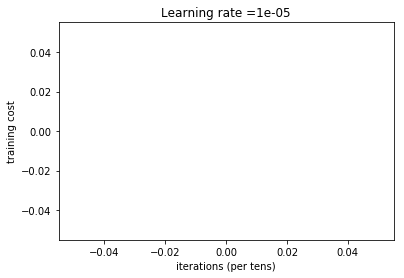

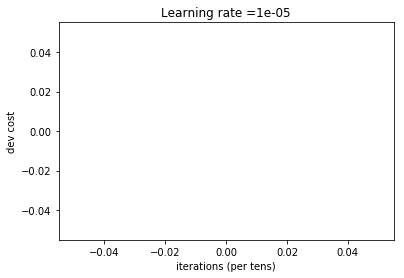

692
counter_tp:  74667.0
counter_tn:  601.0
counter_fp:  8321.0
counter_fn:  5027.0
counter_correct:  39976.0
Train Accuracy: 0.451114922813036
Train Accuracy (binary):  0.8493725738015708
Train F-1 (binary):  0.9179503571384664
[1 1 1 ... 1 1 1]
(6129,)
[ 2  0  1 ...  4  2 14]
(6129,)
Dev Accuracy: 0.3662914015336923
Dev Accuracy (binary):  0.7798988415728504
Dev F-1 (binary):  0.8750347383047706


In [109]:
parameters = model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test)